<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-the-dataset" data-toc-modified-id="Loading-the-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading the dataset</a></span></li><li><span><a href="#Visual-Odometry-functions" data-toc-modified-id="Visual-Odometry-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Visual Odometry functions</a></span></li></ul></div>

In [79]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

# Loading the dataset

In [80]:
class Dataset_Handler():
    def __init__(self, sequence, lidar=True):
        import pandas as pd
        import os
        import cv2
        
        #if handler contains lidar info
        self.lidar = lidar
        
        #file paths and ground truth poses
        self.seq_dir = 'dataset/sequences/{}/'.format(sequence)
        self.poses_dir = 'dataset/poses/{}.txt'.format(sequence)
        poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)
        
        #names of files to iterate through
        self.left_image_files = os.listdir(self.seq_dir + 'image_0')
        self.right_image_files = os.listdir(self.seq_dir + 'image_1')
        self.velodyne_files = os.listdir(self.seq_dir + 'velodyne')
        self.num_frames = len(self.left_image_files)
        self.lidar_path = self.seq_dir + 'velodyne/'
        
        #calibration details for scene, P0 and P1 are Grayscale cams, P2 and P3 are RGB cams
        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3,4))
        self.P2 = np.array(calib.loc['P2:']).reshape((3,4))
        self.P3 = np.array(calib.loc['P3:']).reshape((3,4))
        # This is the transformation matrix for LIDAR
        self.Tr = np.array(calib.loc['Tr:']).reshape((3,4))
        
        #times and ground truth poses
        self.times = np.array(pd.read_csv(self.seq_dir + 'times.txt', delimiter=' ', header=None))
        self.gt = np.zeros((len(poses), 3, 4))
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
        
        #use generators
        self.reset_frames()
        
        #just for testing, store original frame to memory
        self.first_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                           + self.left_image_files[0], 0)
        self.first_image_right = cv2.imread(self.seq_dir + 'image_1/' 
                                           + self.right_image_files[0], 0)
        self.second_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                           + self.left_image_files[1], 0)
        if self.lidar:
            self.first_pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[0],
                                                dtype=np.float32, 
                                                count=-1).reshape((-1, 4))
        self.imheight = self.first_image_left.shape[0]
        self.imwidth = self.first_image_left.shape[1]
            
            
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'image_1/' + name_right, 0)
                            for name_right in self.right_image_files)
        if self.lidar:
            self.pointclouds = (np.fromfile(self.lidar_path + velodyne_file, 
                                            dtype=np.float32, 
                                            count=-1).reshape((-1, 4))
                                for velodyne_file in self.velodyne_files)
        pass

# Visual Odometry functions

In [84]:
#pointlcouds for images
def visualize_pointclouds(img_left, img_right):
    fig = plt.figure(figsize=(7,10))
    ax = fig.add_subplot(221,projection="3d")
    x = img_left[:,0]
    y = img_left[:,1]
    z = img_left[:,2]
    ax.set_box_aspect((np.ptp(x),np.ptp(y),np.ptp(z)))
    ax.scatter(x,y,z,s=0.1)
#     ax.grid(False)
#     ax.axis("off")
    ax.set_title("pointcloud of left image")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.view_init(elev=40, azim=100)
    
    ax = fig.add_subplot(223,projection="3d")
    x = img_right[:,0]
    y = img_right[:,1]
    z = img_right[:,2]
    ax.set_box_aspect((np.ptp(x),np.ptp(y),np.ptp(z)))
    ax.scatter(x,y,z,s=0.1)
#     ax.grid(False)
#     ax.axis("off")
    ax.set_title("pointcloud of right image")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.view_init(elev=40, azim=100)

#generate disparity map
def compute_left_disparity_map(img_left, img_right, matcher='sgbm'):
    
    sad_window = 6
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )

    disparity = matcher.compute(img_left, img_right).astype(np.float32)/16
    return disparity

# to get parameters from the projection matrix
def decompose_projection_matrix(p):

    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

def calc_depth_map(disparity_map, k_left, t_left, t_right, rectified=True):
    
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disparity_map[disparity_map == 0.0] = 0.1
    disparity_map[disparity_map == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disparity_map.shape)
    depth_map = f * b / disparity_map
    
    return depth_map

# coding everything together
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rectified=True):
    
    # display the pointcloud
    visualize_pointclouds(img_left, img_right)
    
    # Compute disparity map
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    fig = plt.figure(figsize=(10,7))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    ax1.set_title("left image")
    ax2.set_title("right image")
    ax3.set_title("disparity map sgbm")
    ax4.set_title("depth map")
    ax1.imshow(img_left)
    ax2.imshow(img_right)
    ax3.imshow(disp)
    ax4.imshow(depth);

    return depth

In [85]:
handler = Dataset_Handler('01')

<IPython.core.display.Javascript object>


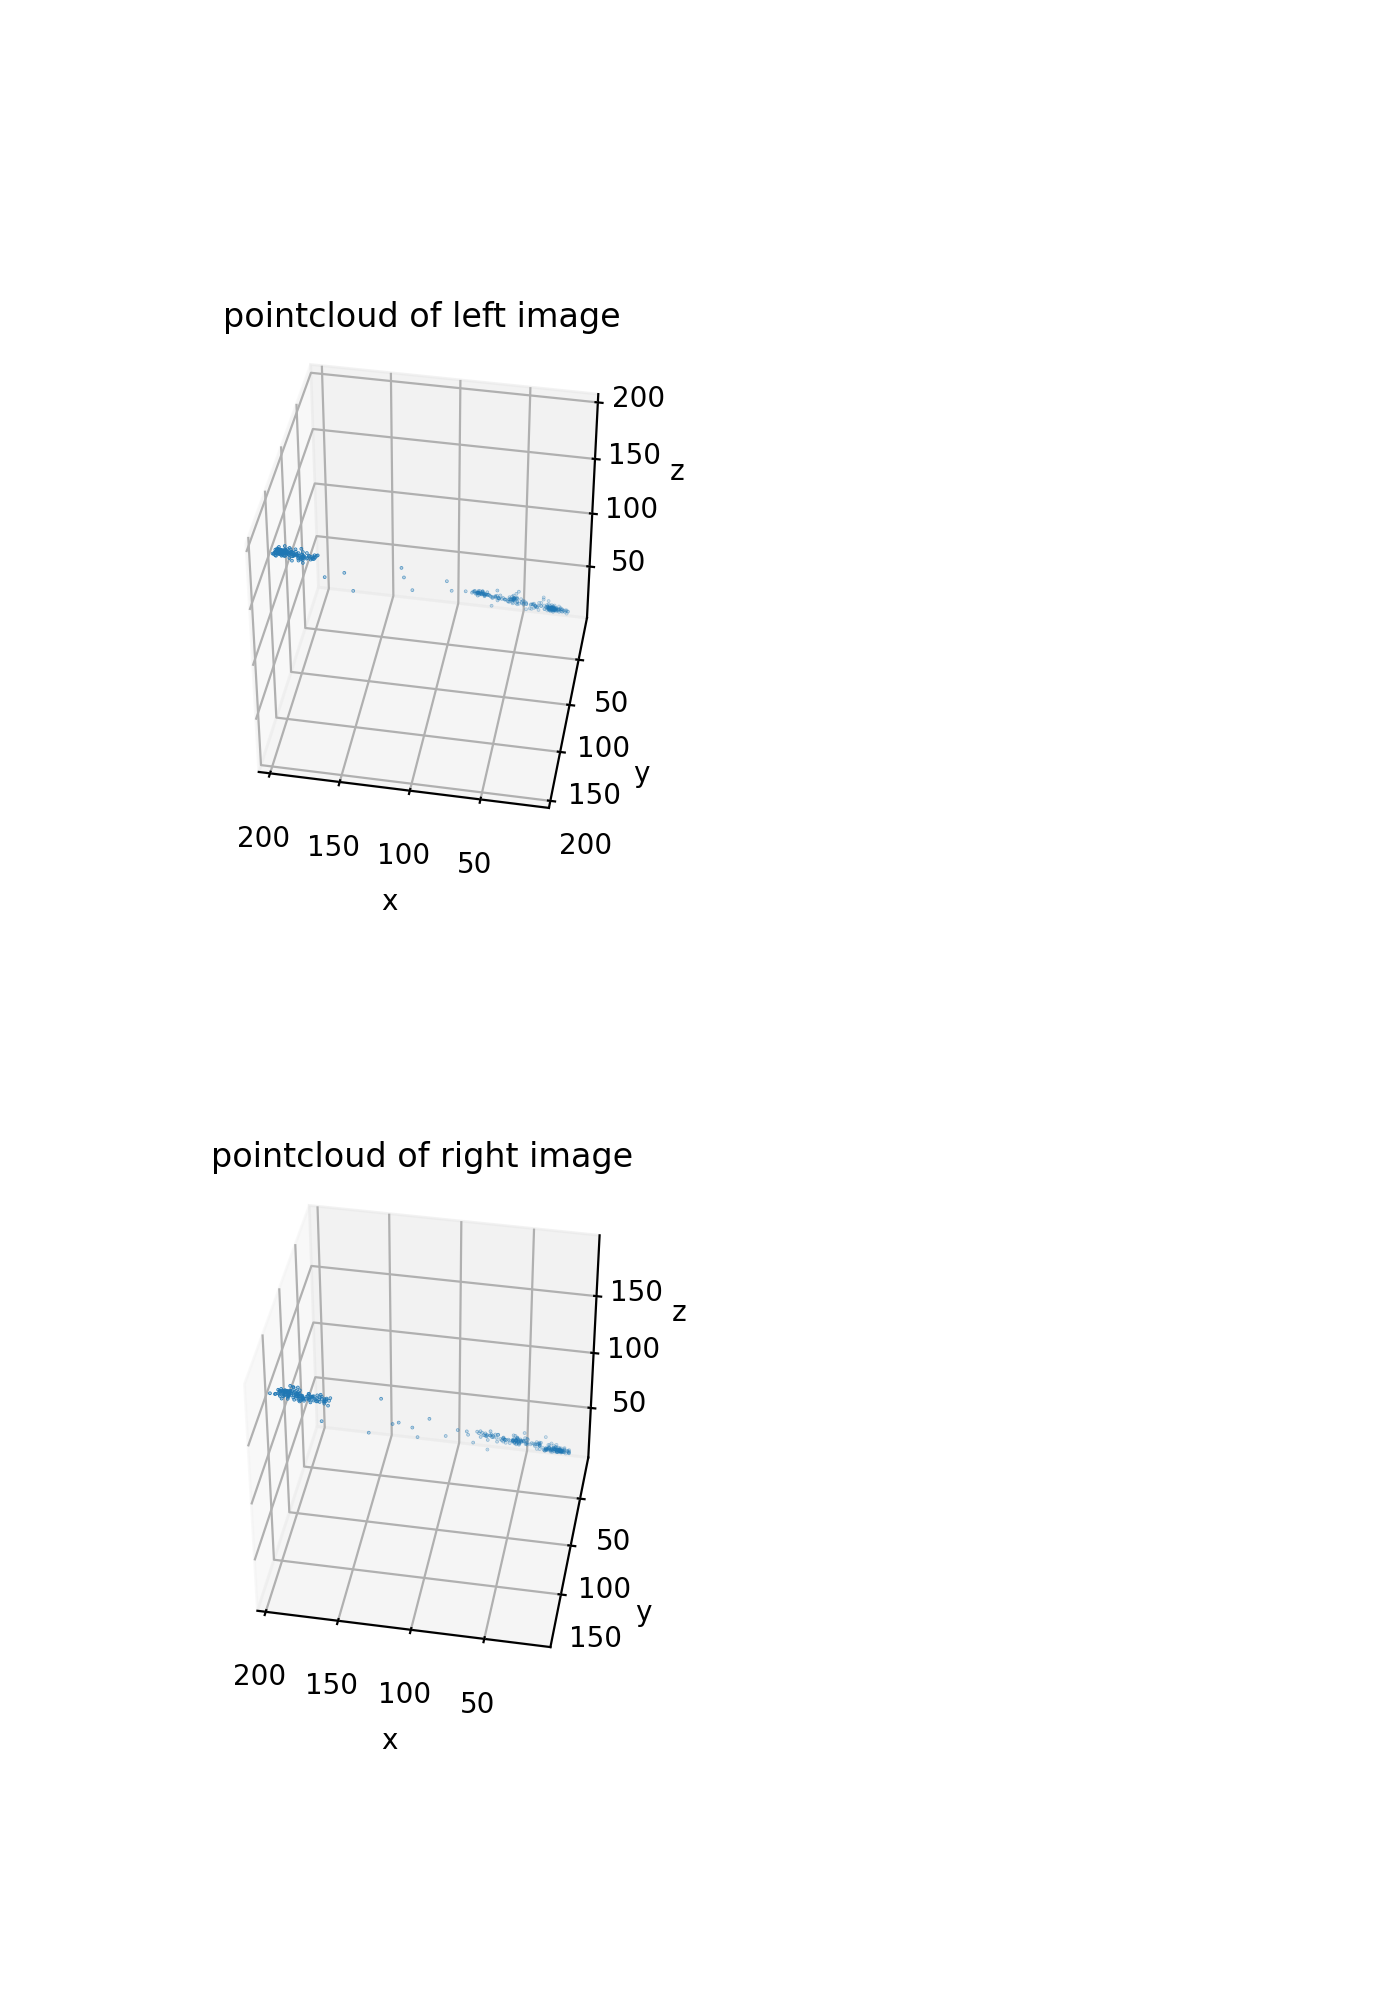

<IPython.core.display.Javascript object>


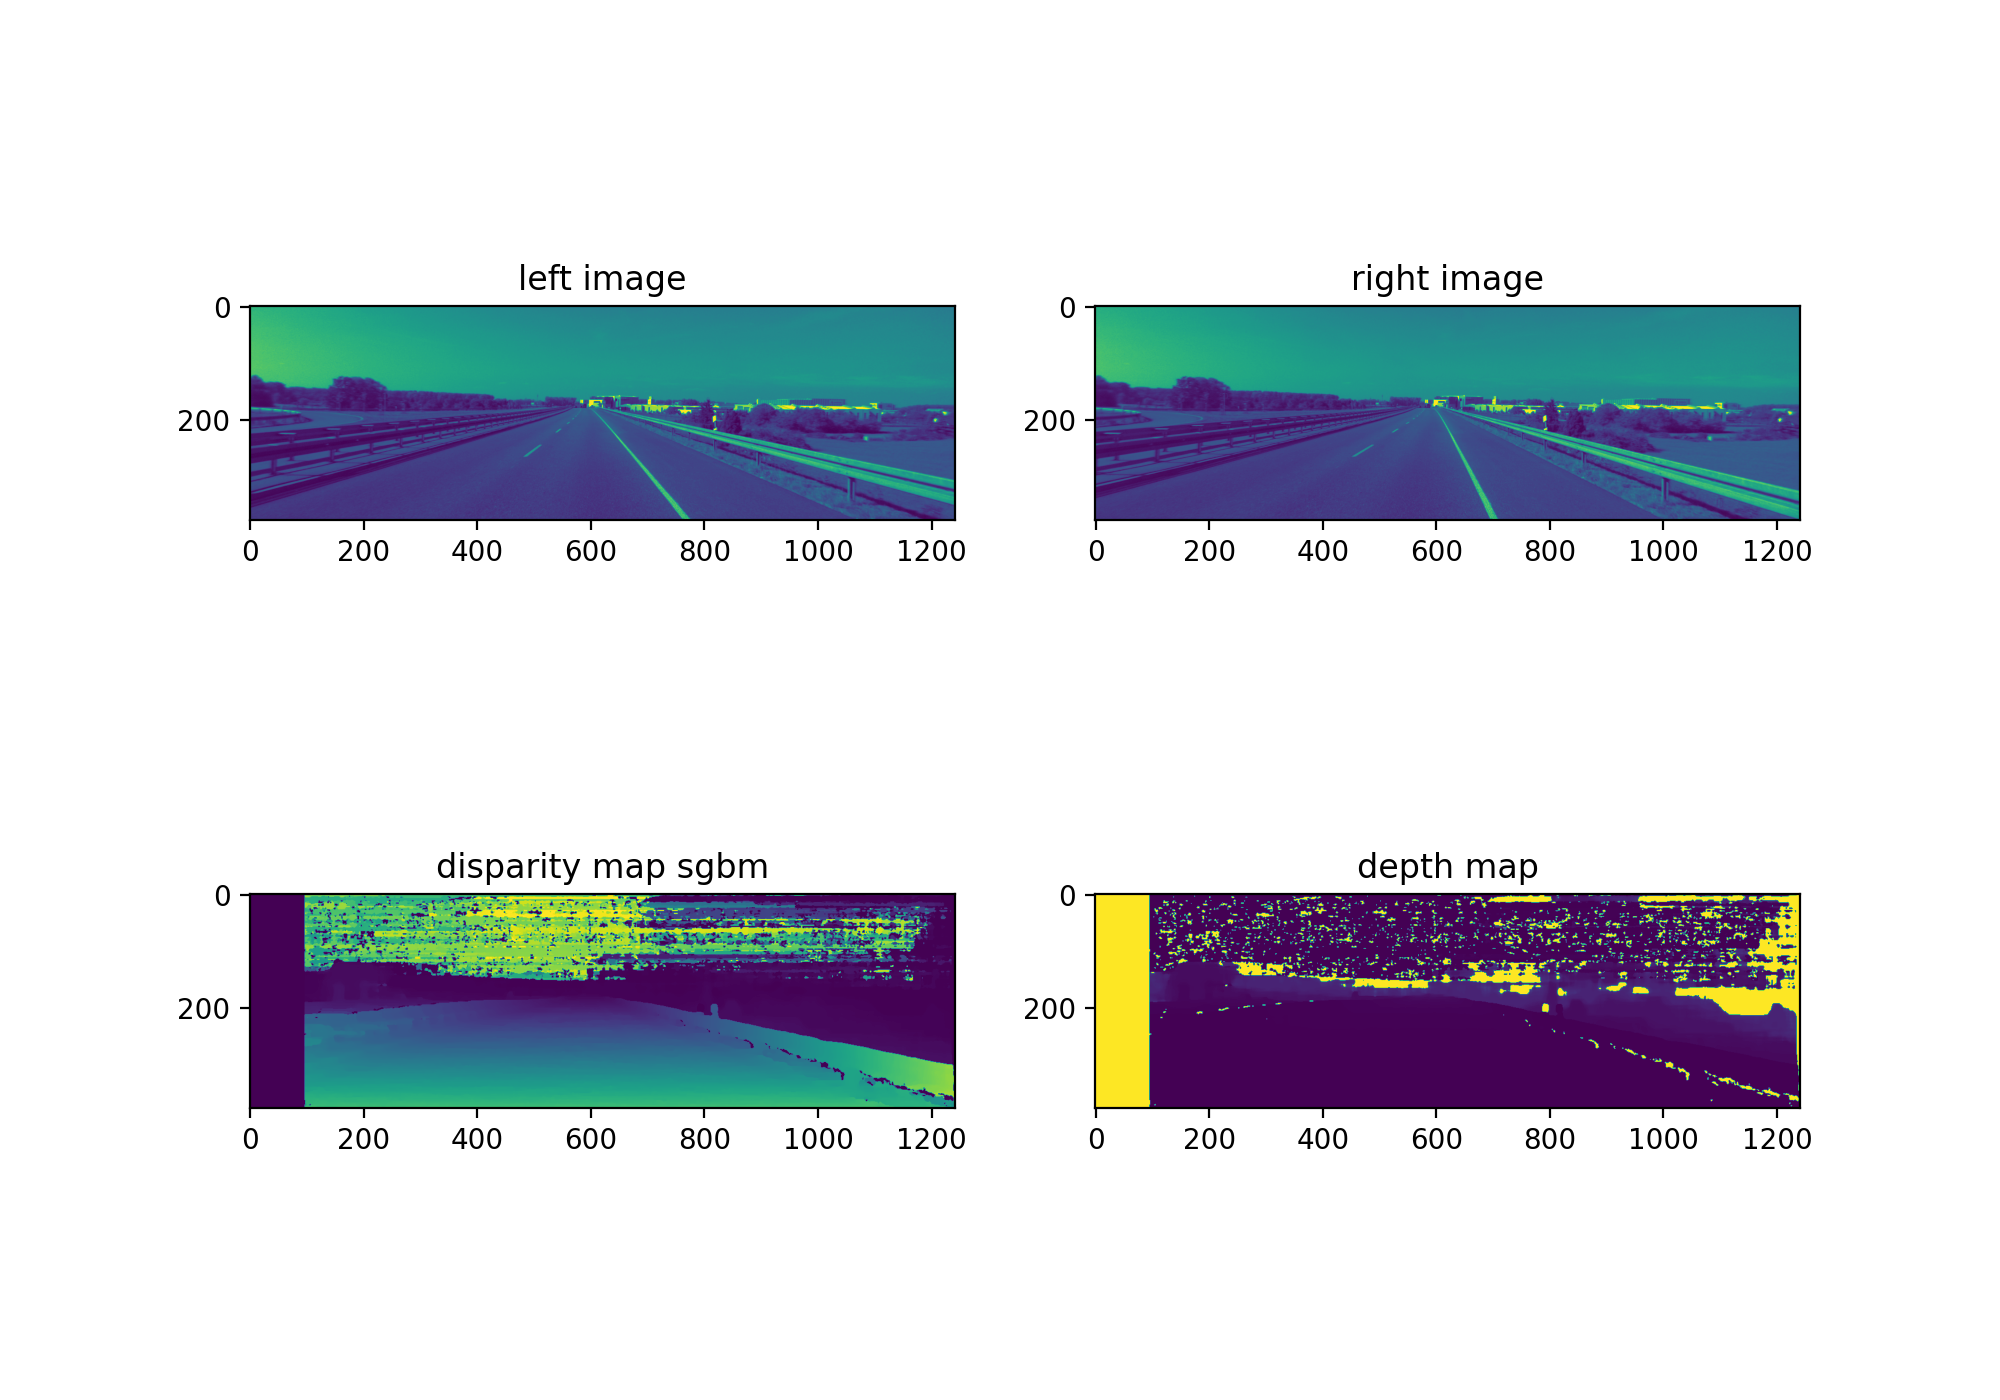

In [86]:
depth_map = stereo_2_depth(handler.first_image_left,
                      handler.first_image_right,
                      handler.P0,
                      handler.P1,
                      matcher="sgbm",
                      rectified="True")